In [ ]:
!pip install --upgrade keras==3.0

In [ ]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import data as tf_data
import os
import keras
from keras import layers
from keras.applications import EfficientNetV2B0

IMAGE_SIZE = (224, 224) # Размер определен выбором модели
BATCH_SIZE = 64

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Разархивируем датасета
# !unzip -u '/content/drive/MyDrive/dogs/stanford_dogs.zip' -d '/content/drive/MyDrive/dogs/'

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/drive/MyDrive/dogs/'

# Определяем список имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

import random
import shutil

# Определяем количество случайных классов, которые нужно выбрать
num_random_classes = 10

# Выбираем случайные 10 классов
random_classes = random.sample(CLASS_LIST, num_random_classes)

# Создаем новую папку для случайных классов
random_class_folder = '/content/drive/MyDrive/random_classes_dogs/'

# Если папка уже существует, удаляем её и создаем заново
if os.path.exists(random_class_folder):
    shutil.rmtree(random_class_folder)
os.makedirs(random_class_folder)

# Копируем папки с фотографиями выбранных случайных классов в новую папку random_classes
for class_name in random_classes:
    source_path = os.path.join(IMAGE_PATH, class_name)
    destination_path = os.path.join(random_class_folder, class_name)
    shutil.copytree(source_path, destination_path)

# Обновляем IMAGE_PATH до новой папки с рандомными классами
IMAGE_PATH = random_class_folder

# Обновляем CLASS_LIST и CLASS_COUNT
CLASS_LIST = random_classes
CLASS_COUNT = num_random_classes

# Выводим обновленное количество классов и список классов
print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

Количество классов: 10
Метки классов: ['Afghan_hound', 'Chow', 'Brittany_spaniel', 'Siberian_husky', 'Dandie_Dinmont', 'Standard_poodle', 'Norfolk_terrier', 'Otterhound', 'Bernese_mountain_dog', 'Sealyham_terrier']


In [ ]:
IMAGE_PATH = '/content/drive/MyDrive/random_classes_dogs/'

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    IMAGE_PATH, # путь к папке с данными
    validation_split=0.2, # отщепляем 20% на проверочную выборку
    subset="both", # указываем, что необходимо вернуть кортеж из обучающей и проверочной выборок ("training", "validation" или "both")
    seed=42,  # воспроизводимость результата генерации (результаты с одинаковым числом - одинаковы),
    shuffle=True, # перемешиваем датасет
    image_size=IMAGE_SIZE, # размер генерируемых изображений
    batch_size=BATCH_SIZE, # размер мини-батча
)

# Определяем список имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Удаляем '.ipynb_checkpoints', если он есть в списке
if '.ipynb_checkpoints' in CLASS_LIST:
    CLASS_LIST.remove('.ipynb_checkpoints')

# Определяем количества классов
CLASS_COUNT = len(CLASS_LIST)

# Вывод результата
print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

Found 1857 files belonging to 10 classes.
Using 1486 files for training.
Using 371 files for validation.
Количество классов: 10
Метки классов: ['Afghan_hound', 'Bernese_mountain_dog', 'Brittany_spaniel', 'Chow', 'Dandie_Dinmont', 'Norfolk_terrier', 'Otterhound', 'Sealyham_terrier', 'Siberian_husky', 'Standard_poodle']


In [ ]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15), # Вращаем изображение в пределах 15%
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # Сдвиг на 10% по вертикали и горизонтали
    layers.RandomFlip(), # Отражение по вертикали и горизонтали
    layers.RandomContrast(factor=0.1), # Изменяем контрастность на 10%
]


def img_augmentation(images):
    # Слои - это функции, которые мы последовательно применяем к входным данным
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

In [ ]:
# Применяем `img_augmentation` к обучающей выборке
train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE, # число потоков для обработки в map (автонастройка зависит от возможностей процессора)
)

val_ds = val_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE, # число потоков для обработки в map (автонастройка зависит от возможностей процессора)
)

# Предварительная выборка примеров в память GPU или оперативную память
# Помогает максимально эффективно использовать графический процессор
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [ ]:
def show_plot(history):
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'b', label='Точность на проверочной выборке')
    plt.title('График точности на обучающей и проверочной выборках')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'b', label='Потери на проверочной выборке')
    plt.title('График потерь на обучающей и проверочной выборках')
    plt.legend()
    plt.show()

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = EfficientNetV2B0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Заморозка предобученных весов
    model.trainable = False

    # Замена верхних слоев
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Компилируем
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )
    return model

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 335s 11s/step - acc: 0.6563 - loss: 1.2363 - val_acc: 0.9757 - val_loss: 0.0906
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 171s 7s/step - acc: 0.8776 - loss: 0.5659 - val_acc: 0.9730 - val_loss: 0.1023
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 177s 7s/step - acc: 0.8869 - loss: 0.5313 - val_acc: 0.9811 - val_loss: 0.0639
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 209s 7s/step - acc: 0.9079 - loss: 0.3889 - val_acc: 0.9677 - val_loss: 0.0819
Epoch 5/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 177s 6s/step - acc: 0.8955 - loss: 0.4681 - val_acc: 0.9838 - val_loss: 0.0340
Epoch 6/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 213s 7s/step - acc: 0.9147 - loss: 0.3129 - val_acc: 0.9838 - val_loss: 0.0382
Epoch 7/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 170s 7s/step - acc: 0.8999 - loss: 0.4663 - val_acc: 0.9946 - val_loss: 0.0185
Epoch 8/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 207s 7s/step - acc: 0.9004 - loss: 0.5253 - val_acc: 0.9919 - val_loss: 0.0190
Epoch 9/15
2

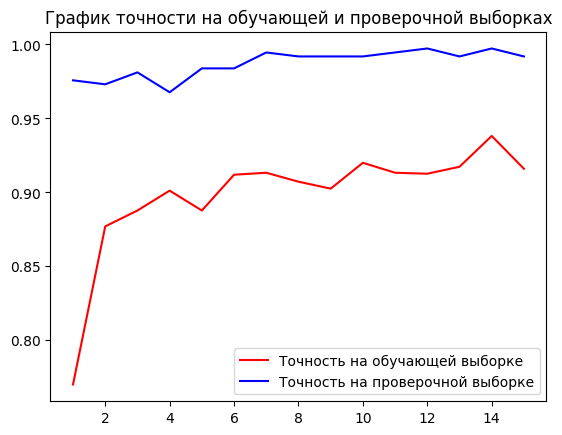

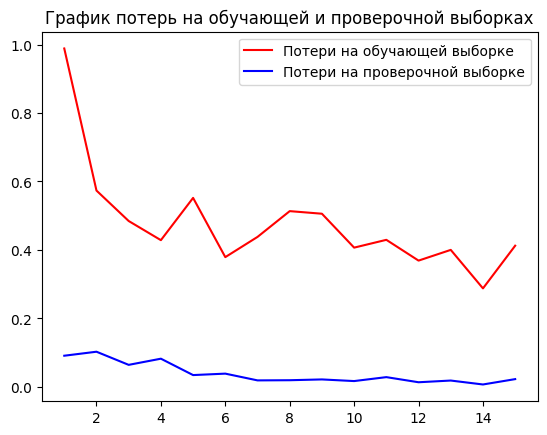

In [ ]:
epochs = 15

callbacks = [
    keras.callbacks.EarlyStopping(
                    monitor='val_acc',
                    mode='max',
                    min_delta=0.001,
                    patience = 10),

    keras.callbacks.ModelCheckpoint(filepath = 'best_model_pretrain.keras',
                             monitor = 'val_acc',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0)
]

model = build_model(num_classes=CLASS_COUNT)


history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

show_plot(history)

In [ ]:
model.save('model_before_timeout.keras')
from google.colab import files
files.download('model_before_timeout.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from keras.models import load_model

# Загрузка модели из файла
model = load_model('/content/drive/MyDrive/model_before_timeout.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:355: UserWarning: Skipping variable loading for optimizer 'adam', because it has 492 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [ ]:
def unfreeze_model(model):
    # Мы размораживаем 20 верхних слоев за исключением BatchNormalization
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    # В оптимизаторе устанавливаем маленький шаг обучения
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )


unfreeze_model(model)

epochs = 4
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
show_plot(history)

model.save('model_before_timeout.keras')

from google.colab import files
files.download('model_before_timeout.keras')